# Crimes in NYC during COVID-19
#### 02806 Social data analysis and visualization F21

## Imports

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import folium
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

In [15]:
crime_2019 = pd.read_csv(root + 'NYPD_Arrest_Data_2019.csv')
crime_2020 = pd.read_csv(root + 'NYPD_Arrest_Data_2020.csv')
covid_data = pd.read_csv(root + "data-by-day.csv")

## 1. MOTIVATION


At the beginning of 2020, COVID-19 hit the world and has had a big impact on the day-to-day life of a big part of the population worldwide. Many social aspects have been affected due to various kinds of restrictions and lockdowns. In this project, we want to have closer look at how the pandemic has affected the rates of various crimes. To do this we chose to focus on New York City (NYC). The reason we decided to look at NYC is that there is a lot of free open data provided for NYC and also because NYC suffered high casualties due to the pandemic during the spring of 2020.

We found three datasets that we chose to use for our analysis:
* COVID-19 case data provided by NYC Department of Health and Mental Hygiene [1]
* Crime dataset, from 2019 and 2020 provided by NYC Open Data [2]

The goal of this project is to spread awareness of the effects of covid-19 on crimes in New York City with the help of interactable figures on a website, where the user follows a narrative that tells the story through the NYPD arrests data, Covid-19 data, and news articles from New York Times. Additionally, we also wanted to include a crime prediction tool where the user, by selecting several parameters, can predict the number of crimes occurring in any of the boroughs of NYC.

Link to the website: https://spacecampboy.github.io/nyc_crime_covid/

## 2. BASIC STATS

### Crime data
The crime data from 2019 and 2020 are fairly similar. Each row contains information concerning a unique arrest. Other than a unique key number and crime category information like date, coordinates, borough, age-group, and sex are given. During our project, we decided to focus on 12 different crimes (see code output below). These crimes were chosen by selecting the ones that were among the most frequently occurring (figure 1) and also showed differences between 2019 and 2020 (figure 3).


In [16]:
focus_crimes = {'PETIT LARCENY', 'DANGEROUS DRUGS', 'ROBBERY', 
                'DANGEROUS WEAPONS', 'BURGLARY',
                'VEHICLE AND TRAFFIC LAWS', 'SEX CRIMES', 'INTOXICATED & IMPAIRED DRIVING',
                'FORGERY', 'CRIMINAL TRESPASS',
                'MURDER & NON-NEGL. MANSLAUGHTE', 'RAPE'}

print("Crime data 2019 Columns: {}, Rows: {}, Crime categories: {}".format(crime_2019.shape[1],crime_2019.shape[0], len(crime_2019['OFNS_DESC'].unique())))
print("Crime data 2020 Columns: {}, Rows: {}, Crime categories: {}".format(crime_2020.shape[1],crime_2020.shape[0], len(crime_2020['OFNS_DESC'].unique())))

print("\nFocus crimes:\n{}".format(", ".join(focus_crimes)))
crime_2019.head(3)

Crime data 2019 Columns: 20, Rows: 214617, Crime categories: 66
Crime data 2020 Columns: 19, Rows: 140413, Crime categories: 62

Focus crimes:
DANGEROUS WEAPONS, ROBBERY, SEX CRIMES, VEHICLE AND TRAFFIC LAWS, BURGLARY, MURDER & NON-NEGL. MANSLAUGHTE, RAPE, PETIT LARCENY, DANGEROUS DRUGS, INTOXICATED & IMPAIRED DRIVING, FORGERY, CRIMINAL TRESPASS


,Unnamed: 0,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,1,192799737,2019-01-26,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,F,M,25,0.0,45-64,M,BLACK,1000555.0,230994.0,40.800694,-73.941109,POINT (-73.94110928599997 40.800694331000045)
1,2,193260691,2019-02-06,NaN,NaN,NaN,NaN,PL 2203400,F,M,14,0.0,25-44,M,UNKNOWN,986685.0,215375.0,40.757839,-73.991212,POINT (-73.99121211099998 40.75783900300007)
2,7,196324211,2019-04-23,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,K,77,0.0,45-64,M,BLACK HISPANIC,1003606.0,185050.0,40.674583,-73.930222,POINT (-73.93022154099998 40.67458330800008)


### COVID-19 data
The covid dataset contains different counts related to covid in NYC, where each row represents a day. The columns show the total count for NYC and all of the five NYC boroughs. NYC Department of Health and Mental Hygiene, who provides the data, constantly updates the dataset. This means the dataset contains data from the first case of covid in NYC 2020-02-29 until the most recent date of the latest version of the data, 2021-04-04 in this case. However, since we don't have crime data from 2021, covid data from this year is not included.


In [17]:
covid_data['date_of_interest'] = pd.to_datetime(covid_data['date_of_interest'])

print("Columns: {}, Rows: {}".format(covid_data.shape[1],covid_data.shape[0]))
print("Date interval: {} - {}".format(str(covid_data['date_of_interest'].min())[:-9],str(covid_data['date_of_interest'].max())[:-9]))
covid_data.head(3)


Columns: 62, Rows: 401
Date interval: 2020-02-29 - 2021-04-04


,date_of_interest,CASE_COUNT,PROBABLE_CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,PROBABLE_DEATH_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,ALL_DEATH_COUNT_7DAY_AVG,BX_CASE_COUNT,BX_PROBABLE_CASE_COUNT,BX_HOSPITALIZED_COUNT,BX_DEATH_COUNT,BX_PROBABLE_DEATH_COUNT,BX_CASE_COUNT_7DAY_AVG,BX_ALL_CASE_COUNT_7DAY_AVG,BX_HOSPITALIZED_COUNT_7DAY_AVG,BX_DEATH_COUNT_7DAY_AVG,BX_ALL_DEATH_COUNT_7DAY_AVG,BK_CASE_COUNT,BK_PROBABLE_CASE_COUNT,BK_HOSPITALIZED_COUNT,BK_DEATH_COUNT,BK_PROBABLE_DEATH_COUNT,BK_CASE_COUNT_7DAY_AVG,BK_ALL_CASE_COUNT_7DAY_AVG,BK_HOSPITALIZED_COUNT_7DAY_AVG,BK_DEATH_COUNT_7DAY_AVG,BK_ALL_DEATH_COUNT_7DAY_AVG,MN_CASE_COUNT,MN_PROBABLE_CASE_COUNT,MN_HOSPITALIZED_COUNT,MN_DEATH_COUNT,MN_PROBABLE_DEATH_COUNT,MN_CASE_COUNT_7DAY_AVG,MN_ALL_CASE_COUNT_7DAY_AVG,MN_HOSPITALIZED_COUNT_7DAY_AVG,MN_DEATH_COUNT_7DAY_AVG,MN_ALL_DEATH_COUNT_7DAY_AVG,QN_CASE_COUNT,QN_PROBABLE_CASE_COUNT,QN_HOSPITALIZED_COUNT,QN_DEATH_COUNT,QN_PROBABLE_DEATH_COUNT,QN_CASE_COUNT_7DAY_AVG,QN_ALL_CASE_COUNT_7DAY_AVG,QN_HOSPITALIZED_COUNT_7DAY_AVG,QN_DEATH_COUNT_7DAY_AVG,QN_ALL_DEATH_COUNT_7DAY_AVG,SI_CASE_COUNT,SI_PROBABLE_CASE_COUNT,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,SI_PROBABLE_DEATH_COUNT,SI_CASE_COUNT_7DAY_AVG,SI_ALL_CASE_COUNT_7DAY_AVG,SI_HOSPITALIZED_COUNT_7DAY_AVG,SI_DEATH_COUNT_7DAY_AVG,SI_ALL_DEATH_COUNT_7DAY_AVG,INCOMPLETE
0,2020-02-29,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-03-01,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2020-03-02,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Preprocessing
The data processing differed depending on the analysis to be performed. However, the date column was initially transformed into a DateTime object and year and month were extracted as new columns. This was done for all the datasets.

In the figures where 2019 crime data is compared with crime data from 2020 the following preprocessing is done:


#### 2019 and 2020 crime data
The date column is tranformed and year and month are extracted.

In [18]:
crime_2019['ARREST_DATE'] = pd.to_datetime(crime_2019['ARREST_DATE'])
crime_2020['ARREST_DATE'] = pd.to_datetime(crime_2020['ARREST_DATE'])
crime_2019['YEAR'] = pd.DatetimeIndex(crime_2019['ARREST_DATE']).year
crime_2019['MONTH'] = pd.DatetimeIndex(crime_2019['ARREST_DATE']).month
crime_2020['YEAR'] = pd.DatetimeIndex(crime_2020['ARREST_DATE']).year
crime_2020['MONTH'] = pd.DatetimeIndex(crime_2020['ARREST_DATE']).month

The two dataframes are concatenaded after selecting only the columns necessary for preparing the figures. During the concatination, potential NAs are removed from the data.  

In [19]:
cols = ['ARREST_KEY','OFNS_DESC', 'YEAR', 'MONTH']
crime_19_filt = crime_2019[cols]
crime_20_filt = crime_2020[cols]
crimes = pd.concat([crime_19_filt, crime_20_filt]).dropna()

Bellow is a barchar showing the count of which the different crimes occur during 2019 and 2020. It was used to select the focus crimes. 

Text(0, 0.5, 'Count')

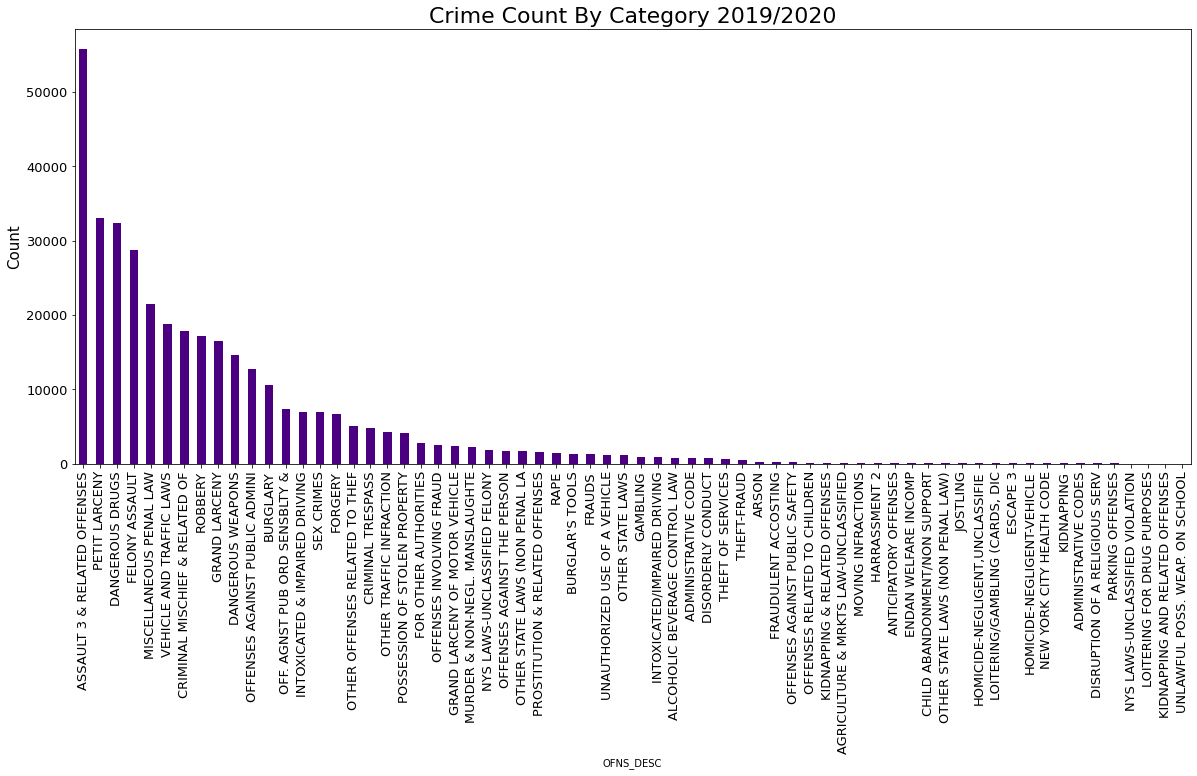

In [20]:
crime_plt = crimes.groupby(['OFNS_DESC']).ARREST_KEY.count().sort_values(ascending=False)
ax = crime_plt.plot(kind='bar', figsize=(20,8), color="indigo", fontsize=13)
ax.set_title("Crime Count By Category 2019/2020", fontsize=22)
ax.set_ylabel("Count", fontsize=15)

Fig 1: Total crime count for each crime category during 2019 and 2020.

The month data is translated into strings from numbers and the dataframe is filtered by the focus crimes.

In [21]:
month_trans = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
               7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
crimes = crimes.replace({'MONTH':month_trans})

crimes_focus = crimes.loc[crimes['OFNS_DESC'].isin(focus_crimes)]

Finally, the data is grouped by: crime, year and month, and counted. 

In [22]:
crimes_grouped = crimes_focus.groupby(['OFNS_DESC','MONTH','YEAR']).count().reset_index()
crimes_grouped = crimes_grouped.rename(columns={"ARREST_KEY": "COUNT"})
crimes_grouped.head(3)

,OFNS_DESC,MONTH,YEAR,COUNT
0,BURGLARY,Apr,2019,361
1,BURGLARY,Apr,2020,520
2,BURGLARY,Aug,2019,407


#### 2020 crime data and COVID data
For the machine learning part and for the figures where COVID and crimes data are combined the preprocessing was done in a slightly different way.

First the date columns are transformed to date obejcts and month is extracted. The date columns are renamed to 'DATE' for both datasets.

In [23]:
covid_data['date_of_interest'] = pd.to_datetime(covid_data['date_of_interest'])
covid_data['MONTH'] = pd.DatetimeIndex(covid_data['date_of_interest']).month

covid_data.rename(columns={'date_of_interest':'DATE'}, inplace=True)
crime_2020.rename(columns={'ARREST_DATE':'DATE'},inplace=True)

The COVID data is filtered, to only include data for 2020. And the the necessary columns are selected.

In [24]:

covid_filtered = covid_data.loc[(covid_data['DATE']>'2020-01-01') & 
                        (covid_data['DATE']<'2021-01-01')]

columns = [col for col in covid_filtered.columns if ((col == 'DATE')  or 
                                                     (col == 'MONTH') or
                                                     (col[3:]=='CASE_COUNT'))]

covid_filtered = covid_filtered[columns]

The borough columns are turned into one column and the borough values are renamed. 

In [25]:
cases_areas = pd.melt(covid_filtered, id_vars=['DATE', 'MONTH'], value_vars=columns[1:-1])
cases_areas.rename(columns={'variable':'BOROUGH','value':'CASE_COUNT'}, inplace=True)
cases_areas.replace({'BOROUGH':{'BX_CASE_COUNT':'THE BRONX', 
                                'MN_CASE_COUNT':'MANHATTAN',
                                'QN_CASE_COUNT':'QUEENS',
                                'SI_CASE_COUNT':'STATEN ISLAND',
                                'BK_CASE_COUNT':'BROOKLYN'}}, inplace=True)
cases_areas.tail(3)

,DATE,MONTH,BOROUGH,CASE_COUNT
1532,2020-12-29,12,STATEN ISLAND,585
1533,2020-12-30,12,STATEN ISLAND,463
1534,2020-12-31,12,STATEN ISLAND,386


There after the 2020 crime data is prepared to enable the merging of the two datasets. First the data is filtered by the focus crimes and values and columns are renamed to comply with the COVID dataset.

In [26]:
crimes_area = crime_2020.loc[crime_2020['OFNS_DESC'].isin(focus_crimes)]
crimes_area = crimes_area[['ARREST_KEY','DATE','MONTH', 'ARREST_BORO', 'OFNS_DESC']]
crimes_area.rename(columns={'ARREST_BORO':'BOROUGH',
                            'OFNS_DESC':'CRIME',
                            'ARREST_KEY':'CRIME_COUNT'}, inplace=True)
crimes_area.replace({'BOROUGH':{'B':'THE BRONX', 
                                'M':'MANHATTAN',
                                'Q':'QUEENS',
                                'S':'STATEN ISLAND',
                                'K':'BROOKLYN'}}, inplace=True)

The crimes are grouped and counted

In [27]:
crimes_area = crimes_area.groupby(['DATE', 'MONTH','BOROUGH','CRIME']).count().reset_index()
crimes_area.tail(3)

,DATE,MONTH,BOROUGH,CRIME,CRIME_COUNT
13799,2020-12-31,12,THE BRONX,PETIT LARCENY,3
13800,2020-12-31,12,THE BRONX,SEX CRIMES,1
13801,2020-12-31,12,THE BRONX,VEHICLE AND TRAFFIC LAWS,2


Finally, the two datasets are merged by the 'DATE', 'BOROUGH' and 'MONTH' variable.

In [28]:
merged_df = pd.merge(cases_areas, crimes_area, on= ['BOROUGH','MONTH','DATE'] )
merged_df.tail(3)

,DATE,MONTH,BOROUGH,CASE_COUNT,CRIME,CRIME_COUNT
11231,2020-12-31,12,STATEN ISLAND,386,PETIT LARCENY,3
11232,2020-12-31,12,STATEN ISLAND,386,ROBBERY,3
11233,2020-12-31,12,STATEN ISLAND,386,VEHICLE AND TRAFFIC LAWS,1


## 3. DATA ANALYSIS



### What we have learn about the dataset
Generally, we find that the overall number of crimes has decreased during 2020 compared to 2019 (figure 2), and this trend is also seen in the majority of our selected focus crimes (figure 3). However, burglary and homicide rate has been increasing during 2020. When plotting the total arrest count against the weekly average of COVID cases over time, a big drop in the number of crimes is seen as COVID hits NYC (figure 4). This might not necessarily mean that the number of a crimes are much less than usually. The New York City Police Department (NYPD) was seriously affected by the pandemic, and many officers got sick after contracting the virus [3]. This could explain the drop in the number of arrests during the initial period of the pandemic. On the NYPD’s website it is stated that 2020 was extraordinary in the number of shootings and homicides compared to previous years [6,4], and this is also what we see in our data with an increased number of homicides and crimes classified as “dangerous weapons”. The increase in the number of burglaries can probably be explained by the increased number of unmanned shops during beginning of the pandemic. During the summer of 2020, we see a peak in the total crime count, and this peak is especially distinct when looking at the total crime count for Manhattan. The reason behind this could probably be due to the turmoil seen around the Black Lives Matter protests that took place during the summer 2020. The presidential election in November 2020 is another factor that might have had an impact on the crime rates [5]. However, we cannot detect any specific changes in the crime data during this period.



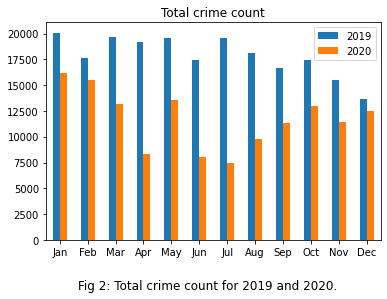

In [29]:
# Generating figure comparing 2019 and 2020 crime counts
bars2019 = crimes[crimes['YEAR']== 2019].groupby('MONTH').ARREST_KEY.count()
bars2020 = crimes[crimes['YEAR']== 2020].groupby('MONTH').ARREST_KEY.count()
index = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df = pd.DataFrame({'2019': bars2019,'2020': bars2020}, index=index)
df.plot.bar(rot=0, title = 'Total crime count')
plt.suptitle("Fig 2: Total crime count for 2019 and 2020.",y=-0.01);plt.show()

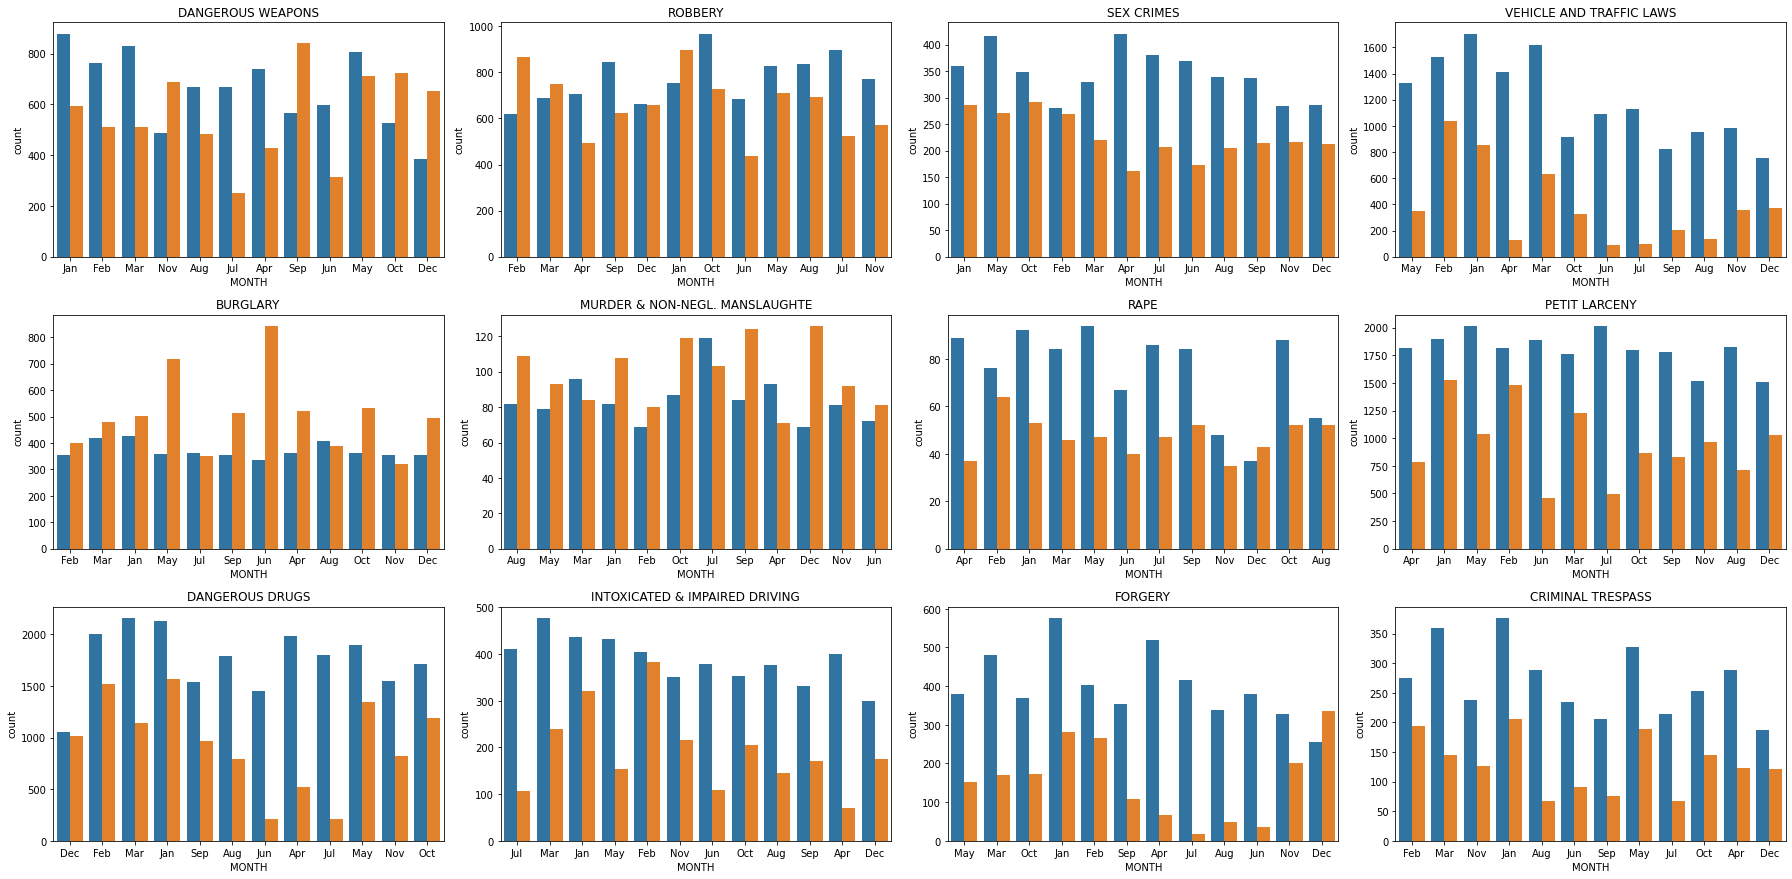

In [30]:
# Generating total crimes count for each of the focus crimes.
plt.figure(figsize=(25,20))
for i, category in enumerate(focus_crimes):
    plt.subplot(5, 4, i + 1)
    plt.title(category)
    sns.countplot(
        data = crimes[crimes['OFNS_DESC']== category],
        x = 'MONTH', 
        hue = 'YEAR')
    plt.legend([], [], frameon=False)
    plt.tight_layout()

Fig 3. Total crime count for each the focus crimes.

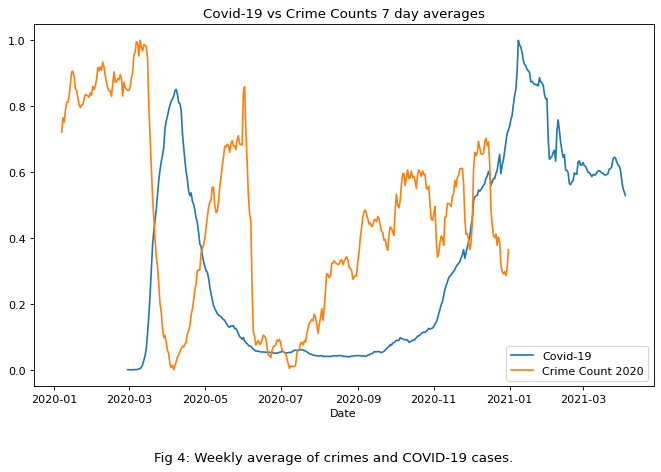

In [31]:
# Generating figure comparing 2020 crime count with COIVD weekly average cases 
arrest_data_2020_grouped_date = crime_2020[["DATE", "ARREST_KEY"]].groupby(["DATE"]).count()
arrest_data_2020_grouped_date.rename({'ARREST_KEY': 'COUNT'}, axis=1, inplace = True)
crime_count_scaled = preprocessing.minmax_scale(arrest_data_2020_grouped_date["COUNT"])
covid_count_scaled = preprocessing.minmax_scale(covid_data["ALL_CASE_COUNT_7DAY_AVG"])
arrest_data_2020_grouped_date['COUNT_SMA_7'] = arrest_data_2020_grouped_date.iloc[:,0].rolling(window=7).mean()
crime_count_sma_scaled = preprocessing.minmax_scale(arrest_data_2020_grouped_date["COUNT_SMA_7"])

plt.figure(figsize=(10, 6), dpi=80)
plt.plot(covid_data["DATE"], covid_count_scaled, label="Covid-19")
plt.plot(arrest_data_2020_grouped_date.index, crime_count_sma_scaled, label="Crime Count 2020")
plt.xlabel('Date');plt.title('Covid-19 vs Crime Counts 7 day averages');plt.legend()
plt.suptitle("Fig 4: Weekly average of crimes and COVID-19 cases.",y=-0.01);plt.show()

### Machine learning

Evaluating our project by predicting the total of crimes based on COVID-19 was neccesary since it is occur based on historical data. Based on multiples researches, data mining techniques have severals methods that can be used to predict crimes, which is by utilizing the data crimes that have occured. With that being said, it is necessary to conduct a comparative analysis of classification algorithms in order to obtain the more accurate predictions results based on the crime data of 2020. There were two classification algorithm analyses in this project. The decision tree and the Random Forest classification. we get an accuracy of 24% for the decision tree classification algorithm while we got a 26% for the Random Forrest Classification. 
With that being said, the random Forrest classification was chosen. 


Use Hot-encoding as we are dealing we will use Random Forrest Classifier

In [32]:
one_hot_df = pd.get_dummies(merged_df)

y = np.array(one_hot_df['CRIME_COUNT'])

X = one_hot_df.drop(['CRIME_COUNT','DATE'], axis = 1)
feature_list = list(X.columns) # list of the features

X = np.array(X)

We split it in training and test data with our features and target

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state = 42)

Now a fit is made on the dataset with a random forest classifier. 

In [34]:
#Initialise the randomforestclassifier as classifier, with 20 estimators

classifier = RandomForestClassifier(n_estimators=20, random_state=42)

# fit the classifier the training set with features and target
classifier.fit(X_train,y_train)

# Predicting the test set
y_pred = classifier.predict(X_test)

# make a prediction on the training set
y_train_pred = classifier.predict(X_train )

print('training set accuracy:')
print(accuracy_score(y_train, y_train_pred))
print('test set accuracy:')
print(accuracy_score(y_test, y_pred))

training set accuracy:
0.9366863246912207
test set accuracy:
0.2590120160213618


The training set is 93% while the test accuarcy is only 25%. This is off course a massive descrepancy that should be taken into consideration.We can conclude by saying that Covid didn't have a lot of effect on the total of Crimes in NYC,this migth be tthe result of the Black lives matter movement, and also according to CBS New York several arrest were made in during the period of the past elections in November 2020. 

## 4. GENRE
#### Genres:
-	Annotated Graph / Map
-	Film / Video / Animation

The annotated graph and animations are used to convey the message to users, thus the genres are Annotated Graph/Map and Film/Video/Animation. A line chart graph is used to show the weekly average for arrest counts and confirmed covid cases with dates as x-axis, allowing users to explore and have a comparative view on any two or more days. Animating would start with an empty graph and draw the lines for each arrest count and covid cases count while showing news articles for each day, giving users a real-time view. 

.
#### Visual Narrative:
- Visual Structuring - Consistent Visual Platform
-	Highlighting - Feature Distinction
-	Transition Guidance - Object Continuity

With all the information available to users, it would have been easy for them to get disoriented therefore the visualizations are structured to be consistent throughout the website, e.g., for example, the same color of line on charts referring to the same color on filters and in the tooltip. Text weight, text size, and colors are used to attract users’ attention and make the distinction between features. Animating the graph also changes the news to provide the transition guidance. Furthermore, hover functionality as part of the narrative structure, also changes the news for the particular day hovered on, orienting the users between transitions. 

.

#### Narrative Structure:
-	Ordering - User Directed Path
-	Interactivity - Filtering/Selection/Search + Hover Highlighting/Details
-	Messaging - Introductory Text

For messaging, introductory text is used to give users insights on the reason behind the visualizations and explaining some of the main features. Thereafter users can choose to explore or run animations. As for interactivity, a New York City Map is added as a filter for each of the city’s boughs and tooltips are used when users hover on chart lines to make a better distinction of line values. 


## 5. VISUALIZATIONS

In [35]:
from IPython.display import Image, HTML, display
def show_image(image_path, caption):
    display(Image(image_path, width=1000, height=400))
    
    display(HTML("<div><i>%s</i></div>" % caption)) 

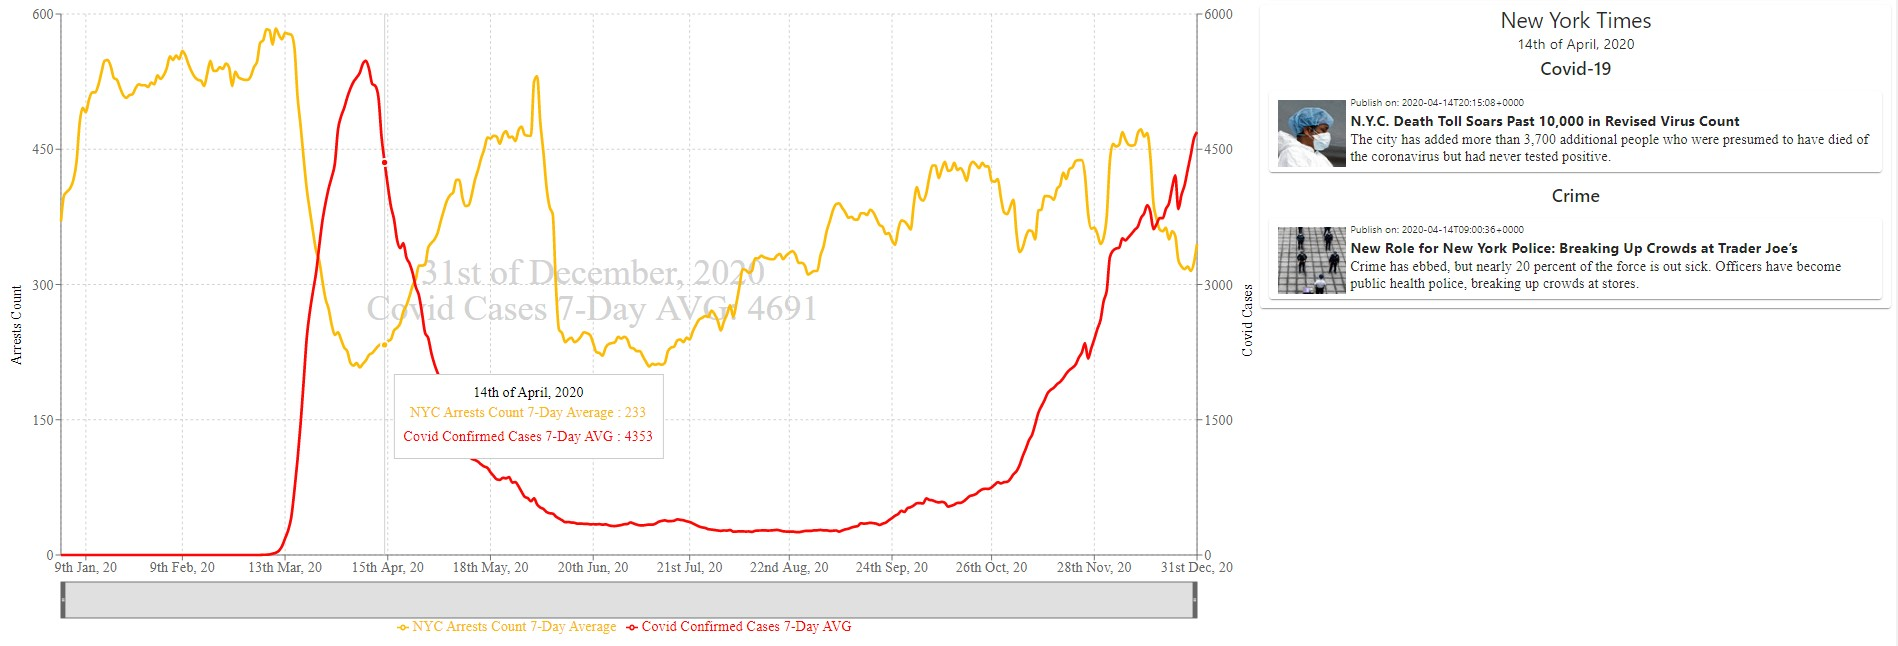

In [36]:
show_image(root + "line-chart-arrests-covid-and-news.jpg", "Figure 5: Line chart for weekly average of NYC Arrests and Confirmed Covid cases")

Figure 5 depicts the main visualizations. A line chart, on the left side, showing the weekly average for New York City arrests (green line) and Covid confirmed cases (red line) and news articles from New York Times on the right side. A line chart is a fine tool for tracking changes over a short or long period of time and using the weekly average for each day, instead of daily count, reduces noise in the data, displaying a smoother line. When hovering over any position on the chart, users can see the average counts for each line on a tooltip for the specific date. The hovering functionality also changes the news to the date hovered on. The interactivity of the line chart and the changing mechanism of the news allows users to compare changes over time and gain insights into extreme irregularities.

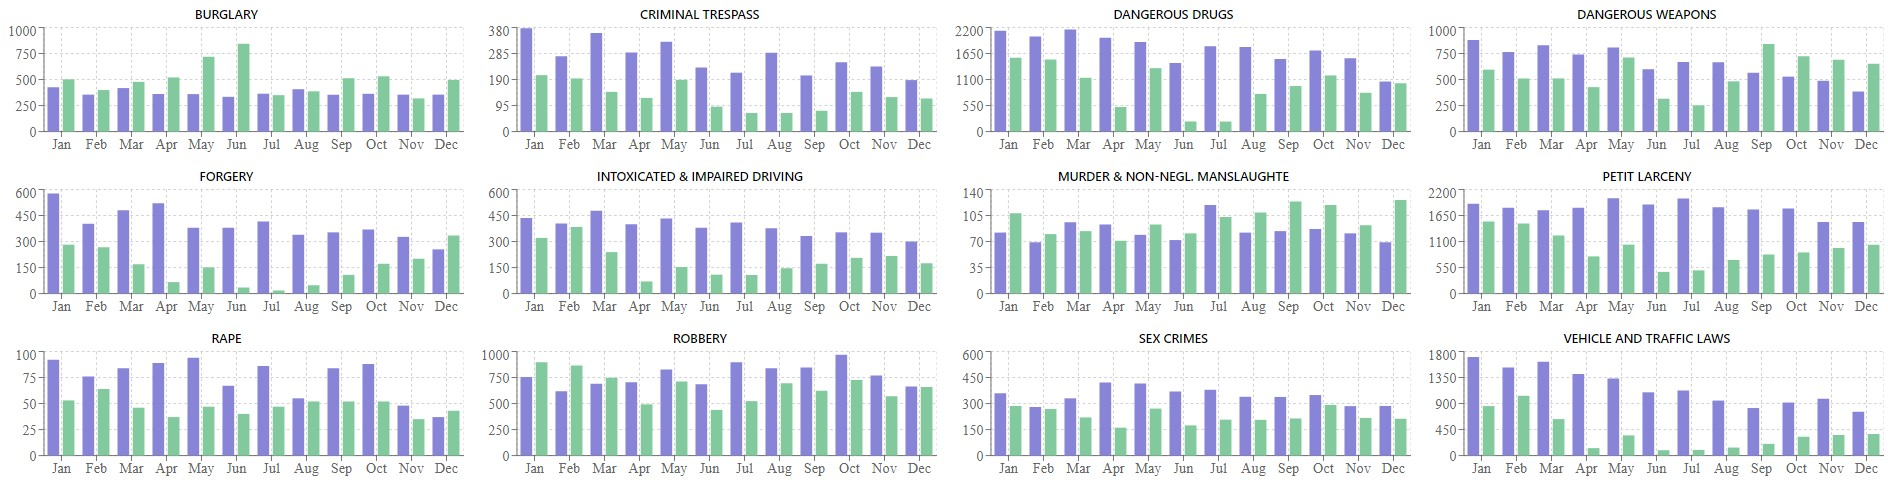

In [37]:
show_image(root + "bar-charts-focus-crimes.jpg", "Figure 6: Bar charts focus crimes")

The second part of the visualization is the bar charts in Figure 6. The bar charts belong to the focus crime categories that were most affected during the outbreak and spread of the covid-19. Each bar chart shows the monthly aggregated arrests count for the years 2019 and 2020, allowing users to compare crime categories on monthly basis for both years, that is with and without covid-19.

## 6. DISCUSSION

Initially, we had some other visualizations in mind when we started the project. We wanted to have a map over NYC were the boroughs would change color depending on the level of corona cases over time. At the same time, we wanted to display locations where crimes occurred using coordinates. The specific crime to be displayed would be selected by the user using a filter next to the map. It turned out to be difficult to combine all these features in one figure and it was quite challenging to combine the COVID data with the crime data in a way that made sense. But, we are very content with how the final result turned out.
 
First, we planned on also including the random forest classifier on the website as a tool for predicting the number of cases of a selected crime. But in the end, we decided not to include it since we got very low accuracy. We believe this is because crime is affected by many factors and predictions are complex to make. As mentioned in the data analysis there were several other factors except for COVID which could have had an impact on the level of crimes for example the "Black Lives Matter" demonstrations during June 2020 and the presidential election in November 2020. 

Names of some crime categories do not directly reflect on the meaning of the crime, such as “assault 3 & related offenses”. We decided to work with the crime categories whose name amd underlying meaning would be clear to the users. However, some of the categories left out were also affected by the pandemic. In the future of the project, we would add these categories and their proper meaning for users’ insight.

## 7. CONTRIBUTIONS

| Student ID| Contributions |
| --- | --- |
| S200116 | Random Forest, Motivation, Basic Stats,Data analysis (what we learned), Discussion |
| S202793 | Website, Genre, Visualizations, Discussion |
| S134682 | Decision Tree, Discussion, Data analysis (machine learning) |

## REFERENCES

1. [NYC Department of Health and Mental Hygiene](https://www1.nyc.gov/site/doh/covid/covid-19-data.page), accessed: 2020-05-12
2. [NYC Open Data](https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u), accessed: 2020-05-12
3. [More than 1,000 New York City police officers have the coronavirus as 911 calls hit records](https://www.cnbc.com/2020/04/01/more-than-1000-new-york-city-police-officers-are-infected-with-coronavirus.html), accessed: 2020-05-12
4. [Violent Year in New York and Across U.S. as Pandemic Fuels Crime Spike](https://www.nytimes.com/2020/12/29/nyregion/nyc-2020-crime-covid.html), accessed: 2020-05-12
5. [Election 2020: At least 50 arrested after attempts to 'hijack peaceful protests' by setting fires in NYC](https://abc7ny.com/election-2020-rally-protest-nyc/7664783/), accessed: 2020-05-12

6. [Overall Crime in New York City Reaches Record Low in 2020](https://www1.nyc.gov/site/nypd/news/p0106a/overall-crime-new-york-city-reaches-record-low-2020), accessed: 2020-05-12

